
# F1 Lap Prediction — End‑to‑End Notebook

This notebook shows an end‑to‑end workflow to:
1) load a Formula 1 session with **FastF1**,
2) extract per‑lap features (including weather and track status),
3) build a driver‑wide feature matrix,
4) train a **RandomForestRegressor** to predict lap time,
5) evaluate and visualise predictions.


In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import fastf1
from fastf1 import plotting as f1plot

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("Versions -> numpy:", np.__version__, "| pandas:", pd.__version__)


Versions -> numpy: 2.1.1 | pandas: 2.2.2



## Configure cache and choose a session

- The cache speeds up repeated data loads.
- You can change `YEAR`, `EVENT_NAME`, and `SESSION_CODE` to explore other races (e.g., `"R"` for race, `"Q"` for qualifying).


In [2]:

# Enable (or create) FastF1 cache for faster subsequent runs
CACHE_DIR = os.path.expanduser("~/.fastf1")
os.makedirs(CACHE_DIR, exist_ok=True)
fastf1.Cache.enable_cache(CACHE_DIR)

# ---- Session parameters (feel free to change) ----
YEAR = 2025
EVENT_NAME = "Austrian Grand Prix"  # example
SESSION_CODE = "R"                   # R=Race, Q=Quali, FP1/2/3, SQ, SSR, etc.


In [3]:

# Load the session with laps, telemetry and weather
session = fastf1.get_session(YEAR, EVENT_NAME, SESSION_CODE)
# laps=True and telemetry=True ensure we can compute speed-based features;
# weather=True provides ambient and track conditions.
session.load(laps=True, telemetry=True, weather=True)
print(f"Loaded session: {YEAR} {EVENT_NAME} [{SESSION_CODE}]")
print("Drivers:", sorted(session.laps['Driver'].dropna().unique().tolist()))


core           INFO 	Loading data for Austrian Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req            INFO 	Data has been written to cache!
req            INFO 	No c

Loaded session: 2025 Austrian Grand Prix [R]
Drivers: ['ALB', 'ALO', 'ANT', 'BEA', 'BOR', 'COL', 'GAS', 'HAD', 'HAM', 'HUL', 'LAW', 'LEC', 'NOR', 'OCO', 'PIA', 'RUS', 'SAI', 'STR', 'TSU', 'VER']



## Feature extraction helpers
We build per‑driver, per‑lap aggregates and then pivot to a global lap matrix.


In [4]:

def extract_driver_lap_features(session):
    """Return a tidy dataframe with one row per (driver, lap) and basic aggregates.
    
    Columns:
      Driver, LapNumber, lap_frac, avg_speed, max_speed,
      tyre_life, pit_in, track_status
    """
    laps = session.laps.copy()
    total = float(laps['LapNumber'].max())
    records = []
    for _, lap in laps.iterlaps():
        # Telemetry-based speed aggregates
        try:
            tel = lap.get_car_data()[['Speed']]
            avg_spd = float(tel['Speed'].mean())
            max_spd = float(tel['Speed'].max())
        except Exception:
            avg_spd, max_spd = np.nan, np.nan
        
        tyre_life = lap.get('TyreLife', np.nan)
        pit_in = int(pd.notna(lap.get('PitInTime', np.nan)))
        lap_frac = float(lap['LapNumber']) / total if total > 0 else np.nan
        status = lap.get('TrackStatus', np.nan)

        records.append({
            'Driver':       lap.get('Driver'),
            'LapNumber':    int(lap.get('LapNumber', 0)),
            'lap_frac':     lap_frac,
            'avg_speed':    avg_spd,
            'max_speed':    max_spd,
            'tyre_life':    tyre_life if pd.notna(tyre_life) else 0.0,
            'pit_in':       pit_in,
            'track_status': status
        })
    df = pd.DataFrame(records)
    # Normalise track_status to simple categories (string)
    df['track_status'] = df['track_status'].astype(str).replace({'nan': '0'})
    return df

def pivot_to_lap_features(df):
    """Pivot (driver, lap) rows into a LapNumber-indexed matrix with driver-suffixed columns."""
    base = df.pivot(index='LapNumber', columns='Driver', values=['avg_speed','max_speed','tyre_life']).sort_index()
    base.columns = [f"{feat}_{drv}" for feat, drv in base.columns]
    base = base.fillna(0.0)
    # One-hot track status per lap
    ts = df[['LapNumber','track_status']].drop_duplicates('LapNumber').set_index('LapNumber')
    ts_ohe = pd.get_dummies(ts['track_status'], prefix='status')
    out = base.join(ts_ohe, how='left').fillna(0.0)
    return out



## Build feature matrix `X` and target `y` (lap time)

We align features with the `LapTime` target (in seconds) and drop missing values.


In [5]:

# Extract tidy per-(driver,lap) features, then pivot to global lap matrix
df_driver_laps = extract_driver_lap_features(session)
X = pivot_to_lap_features(df_driver_laps)

# Target: LapTime in seconds (some laps may have NaT/NaN -> drop)
y_series = session.laps.set_index('LapNumber')['LapTime'].dt.total_seconds()
# Align indices (inner join on LapNumber)
Xy = X.join(y_series.rename('lap_time_s'), how='inner')
Xy = Xy.dropna(subset=['lap_time_s'])

print("Feature matrix shape:", Xy.shape)
Xy.head()


Feature matrix shape: (1124, 66)


,avg_speed_ALB,avg_speed_ALO,avg_speed_ANT,avg_speed_BEA,avg_speed_BOR,avg_speed_COL,avg_speed_GAS,avg_speed_HAD,avg_speed_HAM,avg_speed_HUL,...,tyre_life_SAI,tyre_life_STR,tyre_life_TSU,tyre_life_VER,status_1,status_12,status_124,status_4,status_41,lap_time_s
LapNumber,,,,,,,,,,,,,,,,,,,,,
1.0,150.293333,145.474359,58.614907,140.519802,149.665782,143.40201,152.709239,132.491917,155.433428,132.303653,...,1.0,2.0,1.0,1.0,False,False,True,False,False,88.861
1.0,150.293333,145.474359,58.614907,140.519802,149.665782,143.40201,152.709239,132.491917,155.433428,132.303653,...,1.0,2.0,1.0,1.0,False,False,True,False,False,90.706
1.0,150.293333,145.474359,58.614907,140.519802,149.665782,143.40201,152.709239,132.491917,155.433428,132.303653,...,1.0,2.0,1.0,1.0,False,False,True,False,False,94.202
1.0,150.293333,145.474359,58.614907,140.519802,149.665782,143.40201,152.709239,132.491917,155.433428,132.303653,...,1.0,2.0,1.0,1.0,False,False,True,False,False,96.740
1.0,150.293333,145.474359,58.614907,140.519802,149.665782,143.40201,152.709239,132.491917,155.433428,132.303653,...,1.0,2.0,1.0,1.0,False,False,True,False,False,97.687



### (Optional) Add basic weather features

We can attach simple weather aggregates (first non-null sample) for the session.
For more precision, consider time-matching weather to each lap.


In [6]:

wdf = session.weather_data.copy()
if wdf is not None and not wdf.empty:
    # Use the first available sample as a simple session-level feature
    Xy['air_temp']   = float(wdf['AirTemp'].dropna().iloc[0])
    Xy['track_temp'] = float(wdf['TrackTemp'].dropna().iloc[0])
    Xy['wind_speed'] = float(wdf['WindSpeed'].dropna().iloc[0])
else:
    Xy['air_temp'] = 0.0
    Xy['track_temp'] = 0.0
    Xy['wind_speed'] = 0.0

Xy.head()


,avg_speed_ALB,avg_speed_ALO,avg_speed_ANT,avg_speed_BEA,avg_speed_BOR,avg_speed_COL,avg_speed_GAS,avg_speed_HAD,avg_speed_HAM,avg_speed_HUL,...,tyre_life_VER,status_1,status_12,status_124,status_4,status_41,lap_time_s,air_temp,track_temp,wind_speed
LapNumber,,,,,,,,,,,,,,,,,,,,,
1.0,150.293333,145.474359,58.614907,140.519802,149.665782,143.40201,152.709239,132.491917,155.433428,132.303653,...,1.0,False,False,True,False,False,88.861,29.6,51.3,1.9
1.0,150.293333,145.474359,58.614907,140.519802,149.665782,143.40201,152.709239,132.491917,155.433428,132.303653,...,1.0,False,False,True,False,False,90.706,29.6,51.3,1.9
1.0,150.293333,145.474359,58.614907,140.519802,149.665782,143.40201,152.709239,132.491917,155.433428,132.303653,...,1.0,False,False,True,False,False,94.202,29.6,51.3,1.9
1.0,150.293333,145.474359,58.614907,140.519802,149.665782,143.40201,152.709239,132.491917,155.433428,132.303653,...,1.0,False,False,True,False,False,96.740,29.6,51.3,1.9
1.0,150.293333,145.474359,58.614907,140.519802,149.665782,143.40201,152.709239,132.491917,155.433428,132.303653,...,1.0,False,False,True,False,False,97.687,29.6,51.3,1.9



## Train a Random Forest regressor


In [9]:
# Split
features = Xy.drop(columns=['lap_time_s'])
target = Xy['lap_time_s']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Train model
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# 兼容旧版本 sklearn：手动取平方根得到 RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R2: {r2:.3f}\nMAE: {mae:.3f} s\nRMSE: {rmse:.3f} s")


R2: 0.815
MAE: 1.537 s
RMSE: 3.087 s



## Visualise predictions vs. actual lap times


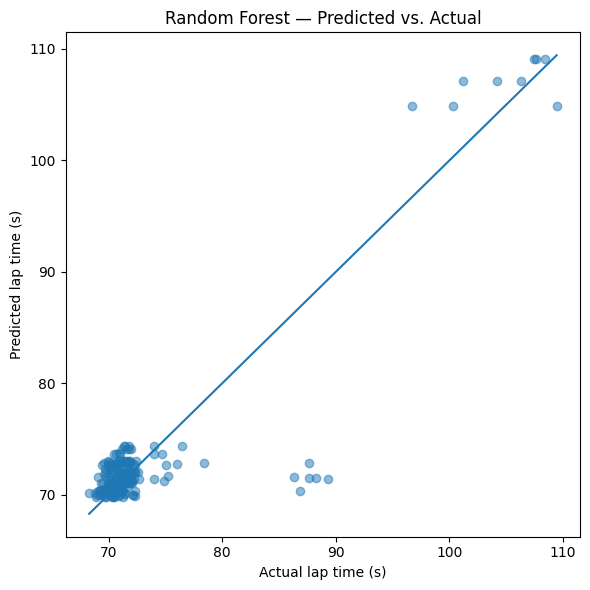

In [10]:

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims)  # y=x reference
plt.xlabel("Actual lap time (s)")
plt.ylabel("Predicted lap time (s)")
plt.title("Random Forest — Predicted vs. Actual")
plt.tight_layout()
plt.show()



## Inspect top feature importances


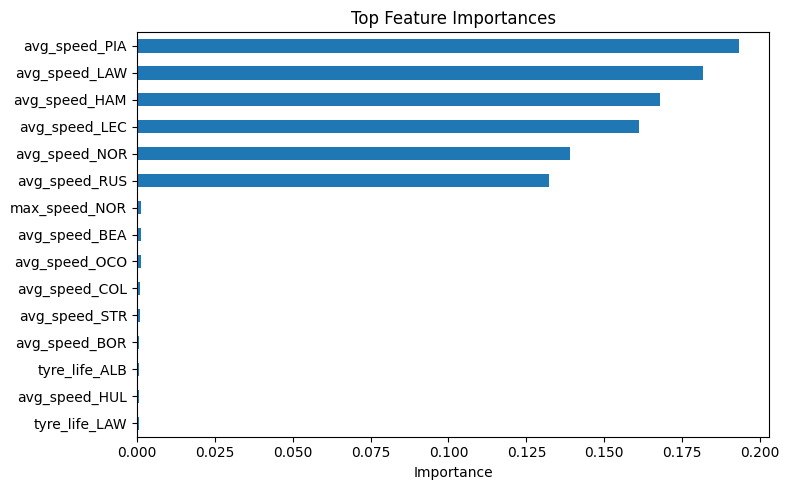

avg_speed_PIA    0.193305
avg_speed_LAW    0.181769
avg_speed_HAM    0.168013
avg_speed_LEC    0.161274
avg_speed_NOR    0.138912
avg_speed_RUS    0.132103
max_speed_NOR    0.001322
avg_speed_BEA    0.001219
avg_speed_OCO    0.001194
avg_speed_COL    0.001054
avg_speed_STR    0.001033
avg_speed_BOR    0.000848
tyre_life_ALB    0.000823
avg_speed_HUL    0.000773
tyre_life_LAW    0.000694
dtype: float64

In [11]:

importances = pd.Series(rf.feature_importances_, index=features.columns).sort_values(ascending=False)
topk = importances.head(15)
plt.figure(figsize=(8,5))
topk[::-1].plot(kind='barh')
plt.xlabel("Importance")
plt.title("Top Feature Importances")
plt.tight_layout()
plt.show()

topk



## (Optional) Save artefacts


In [12]:

# Save the trained model and last feature matrix for later reuse (optional)
try:
    import joblib
    joblib.dump(rf, "rf_model.joblib")
    features.to_parquet("features.parquet")
    print("Saved rf_model.joblib and features.parquet in the current directory.")
except Exception as e:
    print("Skipping save (joblib or parquet not available):", e)


Skipping save (joblib or parquet not available): Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.



## Appendix: quick data peek


In [13]:

print("Driver‑lap features (head):")
display(df_driver_laps.head())

print("\nPivoted X (head):")
display(X.head())

print("\nFinal training table (head):")
display(Xy.head())


Driver‑lap features (head):


,Driver,LapNumber,lap_frac,avg_speed,max_speed,tyre_life,pit_in,track_status
0,NOR,1,0.014286,169.583851,298.0,1.0,0,124
1,NOR,2,0.028571,134.695035,263.0,2.0,0,4
2,NOR,3,0.042857,137.774038,278.0,3.0,0,41
3,NOR,4,0.057143,223.376426,300.0,4.0,0,1
4,NOR,5,0.071429,222.435606,300.0,5.0,0,1



Pivoted X (head):


,avg_speed_ALB,avg_speed_ALO,avg_speed_ANT,avg_speed_BEA,avg_speed_BOR,avg_speed_COL,avg_speed_GAS,avg_speed_HAD,avg_speed_HAM,avg_speed_HUL,...,tyre_life_RUS,tyre_life_SAI,tyre_life_STR,tyre_life_TSU,tyre_life_VER,status_1,status_12,status_124,status_4,status_41
LapNumber,,,,,,,,,,,,,,,,,,,,,
1,150.293333,145.474359,58.614907,140.519802,149.665782,143.402010,152.709239,132.491917,155.433428,132.303653,...,1.0,1.0,2.0,1.0,1.0,False,False,True,False,False
2,140.251852,142.037594,0.000000,145.416244,139.962963,143.451777,140.054054,148.557333,139.689487,146.829016,...,2.0,0.0,3.0,2.0,0.0,False,False,False,True,False
3,144.621134,145.513089,0.000000,148.492021,145.881137,147.343832,143.408163,146.182306,141.384615,155.120787,...,3.0,0.0,4.0,3.0,0.0,False,False,False,False,True
4,213.386029,210.601449,0.000000,210.177536,213.190476,211.144928,214.110701,213.563177,216.250000,212.823105,...,4.0,0.0,5.0,4.0,0.0,True,False,False,False,False
5,215.902985,214.104478,0.000000,214.563433,215.962963,212.915129,217.817844,215.180147,219.533582,214.291513,...,5.0,0.0,6.0,5.0,0.0,True,False,False,False,False



Final training table (head):


,avg_speed_ALB,avg_speed_ALO,avg_speed_ANT,avg_speed_BEA,avg_speed_BOR,avg_speed_COL,avg_speed_GAS,avg_speed_HAD,avg_speed_HAM,avg_speed_HUL,...,tyre_life_VER,status_1,status_12,status_124,status_4,status_41,lap_time_s,air_temp,track_temp,wind_speed
LapNumber,,,,,,,,,,,,,,,,,,,,,
1.0,150.293333,145.474359,58.614907,140.519802,149.665782,143.40201,152.709239,132.491917,155.433428,132.303653,...,1.0,False,False,True,False,False,88.861,29.6,51.3,1.9
1.0,150.293333,145.474359,58.614907,140.519802,149.665782,143.40201,152.709239,132.491917,155.433428,132.303653,...,1.0,False,False,True,False,False,90.706,29.6,51.3,1.9
1.0,150.293333,145.474359,58.614907,140.519802,149.665782,143.40201,152.709239,132.491917,155.433428,132.303653,...,1.0,False,False,True,False,False,94.202,29.6,51.3,1.9
1.0,150.293333,145.474359,58.614907,140.519802,149.665782,143.40201,152.709239,132.491917,155.433428,132.303653,...,1.0,False,False,True,False,False,96.740,29.6,51.3,1.9
1.0,150.293333,145.474359,58.614907,140.519802,149.665782,143.40201,152.709239,132.491917,155.433428,132.303653,...,1.0,False,False,True,False,False,97.687,29.6,51.3,1.9
